# Online MLP training on a subspace using SMC

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from jax.flatten_util import ravel_pytree
from functools import partial
from chex import ArrayDevice
from collections.abc import Callable
from tensorflow_probability.substrates import jax as tfp
from sklearn.metrics import confusion_matrix

tfd = tfp.distributions

2022-09-09 07:04:56.202597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
jnp.set_printoptions(linewidth=200, suppress=True)

In [100]:
class MLP(nn.Module):
    n_hidden: int
    n_out: int
    activation: Callable[[ArrayDevice], ArrayDevice] = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

def fz(W):
    return W


def f(x):
    return x - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3


def sample_observations(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle = jax.random.split(key, 3)
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    X = jnp.c_[x, y]

    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    X, y = jnp.array(X[shuffled_ixs, :].T)
    return X, y


def generate_train_test_data(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    x, y = sample_observations(key, f, n_obs, xmin, xmax, x_noise, y_noise)
    xtest = jnp.linspace(x.min(), x.max(), n_obs)
    return (x, y), (xtest, f(xtest))

In [101]:
key = jax.random.PRNGKey(314)
key_sample_obs, key_weights, key_particles_init, key_smc, key_dummy, key_pm = jax.random.split(key, 6)

Text(0.5, 1.0, 'Training data')

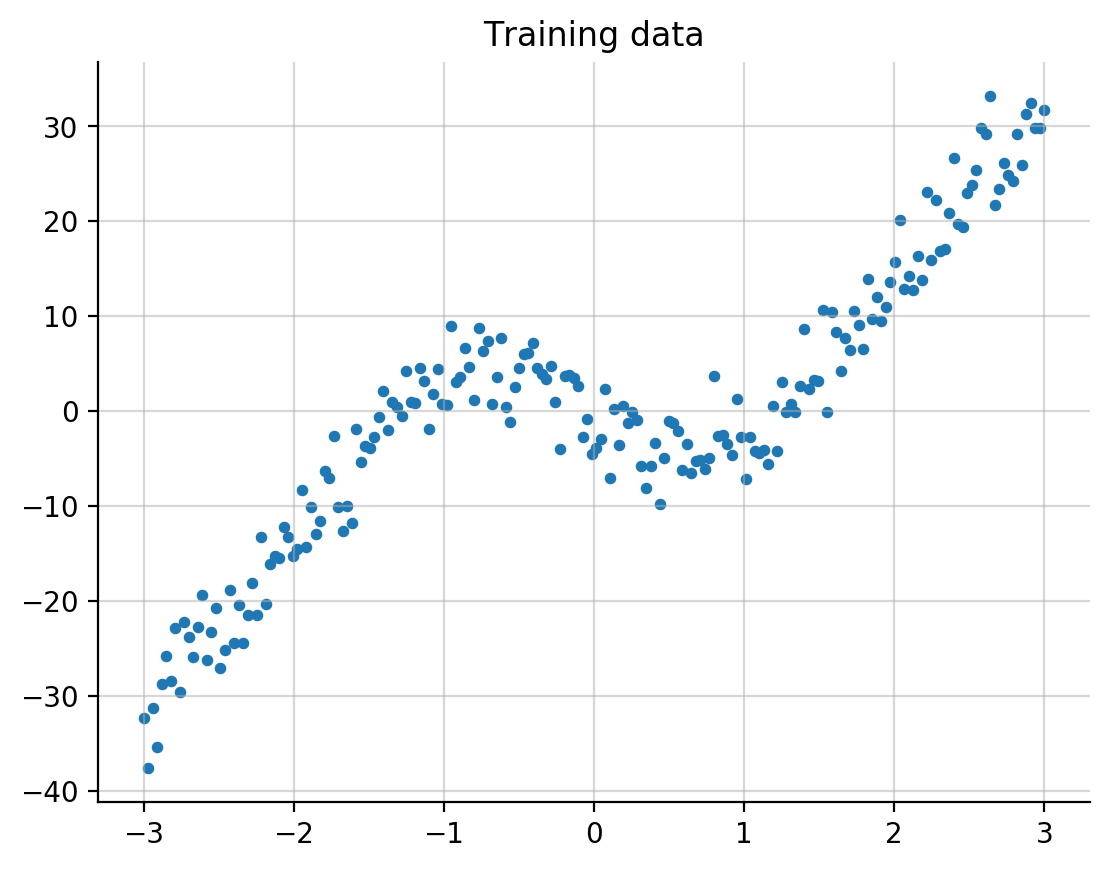

In [102]:
n_obs = 200
xmin, xmax = -3, 3
xnoise, ynoise = 0.0, 3.0
(x, y), (xtest, ytest) = generate_train_test_data(key_sample_obs, f, n_obs,
                                                  xmin, xmax, xnoise, ynoise)
plt.scatter(x, y, s=10)
plt.grid(alpha=0.5)
plt.title("Training data")

## SMC sampling

In [103]:
# Suppose we know the standard deviation of the observations
alpha = 3.0

def smc_step(state, xs, reconstruct_fn, projection_matrix, scale=0.1):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=scale)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    mean_obs = jax.vmap(model.apply, (0, None))(particles_full, xobs[None]).ravel()
    dist_obs = tfd.Normal(loc=mean_obs, scale=alpha)
    
    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "log_weights": log_weights_next,
        "particles": particles_next
    }
    
    return state_next, memory

In [104]:
n_particles = 500
model = MLP(n_hidden=10, n_out=1)
batch = jnp.ones((1, 1))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [105]:
# q(θ{1})
dim_full = len(params_all_flat)
dim_subspace = 10
proj_matrix = jax.random.bernoulli(key_pm, shape=(dim_full, dim_subspace)).astype(float)
particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))

In [127]:
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, x, y)
part_smc_step = partial(smc_step,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        scale=0.1)
(_, particles_final_sub), hist = jax.lax.scan(part_smc_step, init_state, xs)

In [128]:
particles_hist = hist["particles"]

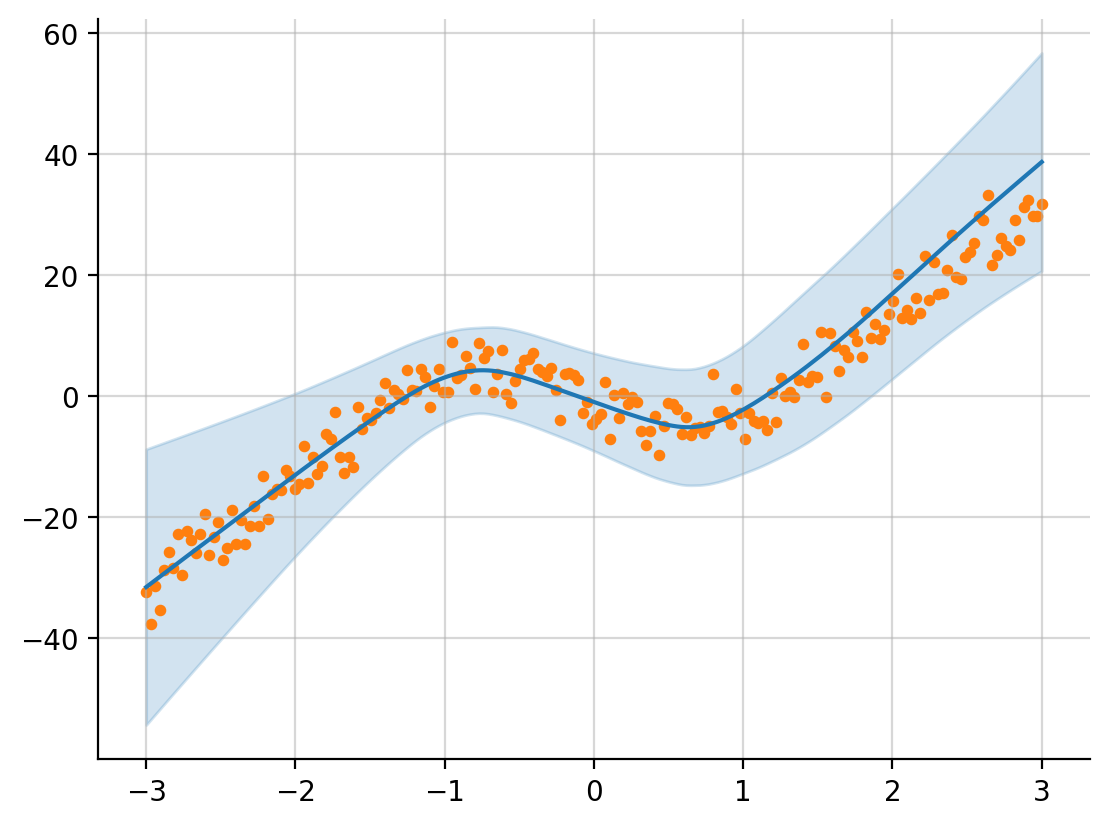

In [129]:
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

f_particles = jax.vmap(model.apply, (0, None))(particles_final, xtest[:, None])[..., 0]
yhat_mean = f_particles.mean(axis=0)
yhat_std = f_particles.std(axis=0)

plt.plot(xtest, yhat_mean)
plt.fill_between(xtest, yhat_mean - 2 * yhat_std, yhat_mean + 2 * yhat_std, color="tab:blue", alpha=0.2)
plt.scatter(x, y, s=10, c="tab:orange")
plt.grid(alpha=0.5)

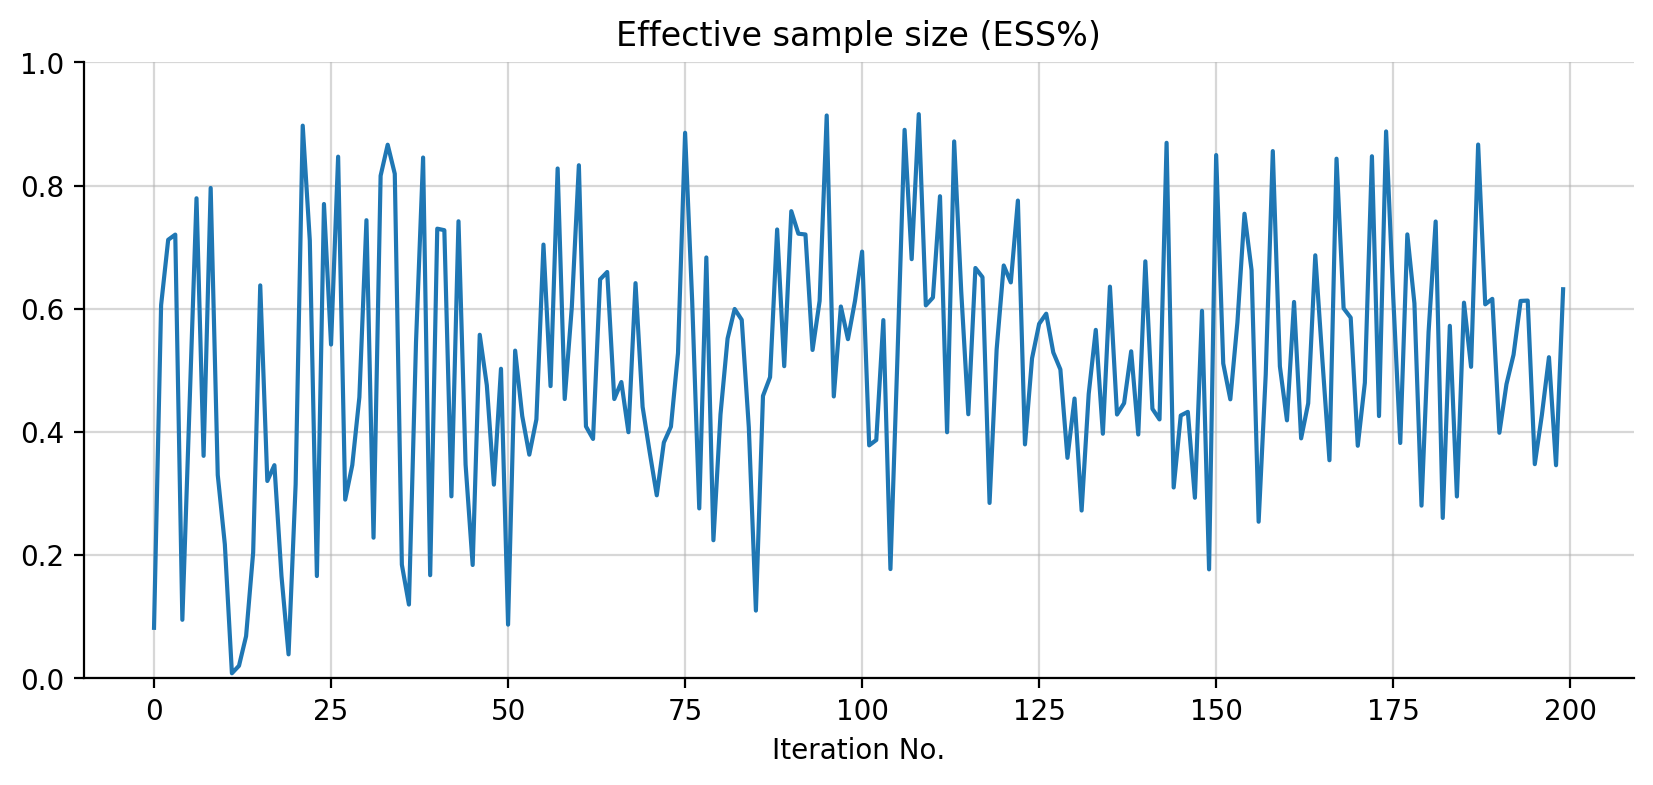

In [133]:
weights_hist = jnp.exp(hist["log_weights"] - jax.nn.logsumexp(hist["log_weights"], axis=-1, keepdims=True))

ess = 1 / jnp.power(weights_hist, 2).sum(axis=1)
ess = ess / n_particles

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ess)
ax.set_title("Effective sample size (ESS%)")
ax.set_xlabel("Iteration No.")
plt.ylim(0, 1)
ax.grid(alpha=0.5)

## Classification (2D)

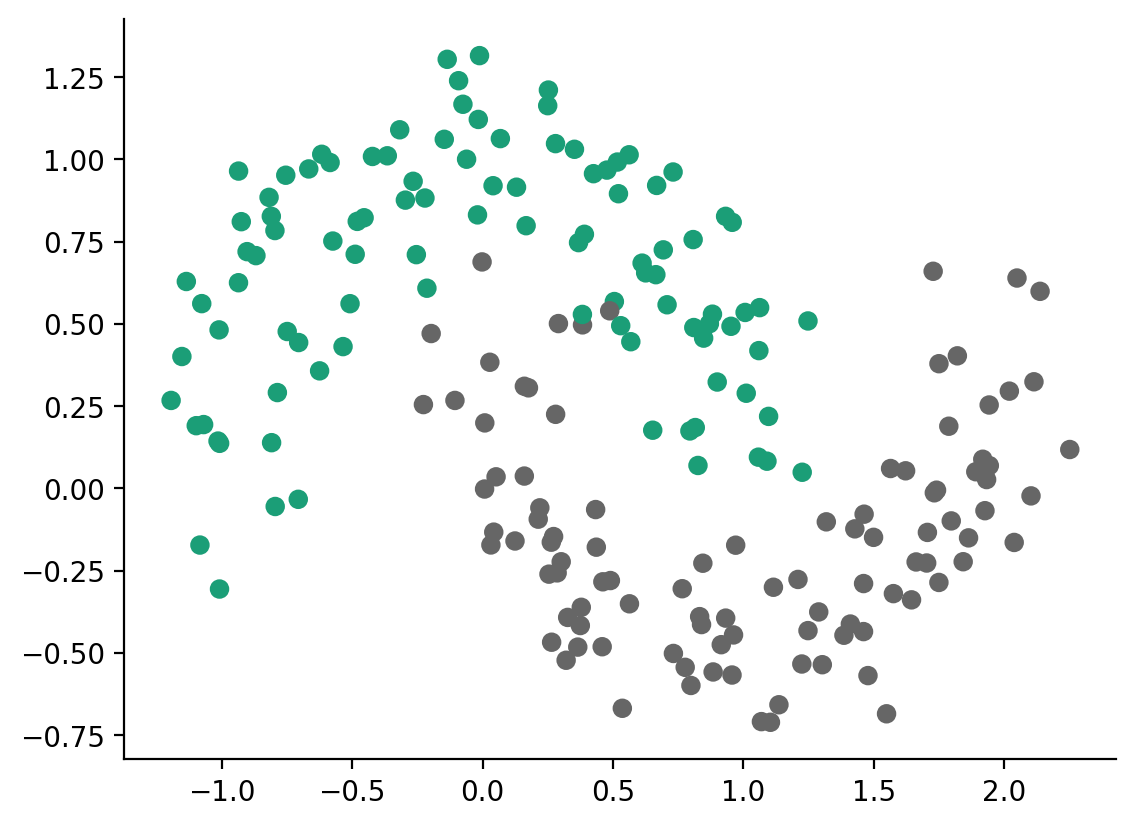

In [134]:
n_obs = 200
X, y = make_moons(n_samples=n_obs, random_state=314, noise=0.15)
y_ohe = jax.nn.one_hot(y, num_classes=2)
plt.scatter(*X.T, c=y, cmap="Dark2")

In [135]:
def smc_step(state, xs, reconstruct_fn, projection_matrix, dim_output, scale=0.1):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=scale)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs)
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "log_weights": log_weights_next,
        "particles": particles_next
    }
    
    return state_next, memory

In [136]:
n_particles = 500
model = MLP(n_hidden=20, n_out=2)
batch = jnp.ones((1, 2))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [137]:
# q(θ{1})
dim_full = len(params_all_flat)
dim_subspace = 10
proj_matrix = jax.random.bernoulli(key_pm, shape=(dim_full, dim_subspace)).astype(float)
particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))
print(proj_matrix.shape)

In [138]:
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, X, y_ohe)
part_smc_step = partial(smc_step,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=2)
(_, particles_final_sub), hist = jax.lax.scan(part_smc_step, init_state, xs)
hist_weights = jnp.exp(hist["log_weights"] - jax.nn.logsumexp(hist["log_weights"], axis=-1, keepdims=True))

In [139]:
vmin, vmax = X.min(), X.max()
step = 0.1
grid = jnp.mgrid[vmin:vmax+step:step, vmin:vmax+step:+step]

In [140]:
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

In [141]:
apply_grid = jax.vmap(model.apply, (0, None))
apply_grid = jax.vmap(apply_grid, (None, 1), out_axes=0)
apply_grid = jax.vmap(apply_grid, (None, 2), out_axes=1)

(-1.1939289455734807, 2.2516078435554183)

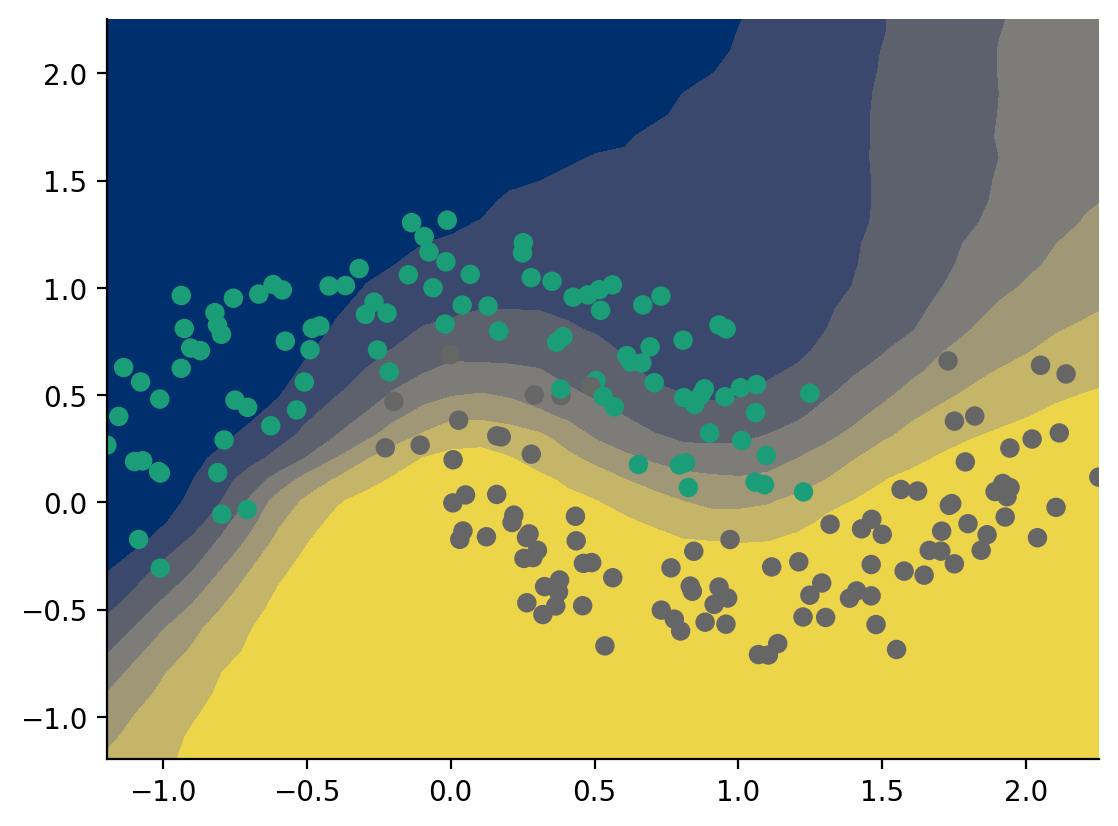

In [142]:
P = apply_grid(particles_final, grid).argmax(axis=-1).mean(axis=-1)
plt.contourf(*grid, P, cmap="cividis")
plt.scatter(*X.T, c=y, cmap="Dark2")
plt.xlim(vmin, vmax)
plt.ylim(vmin, vmax)

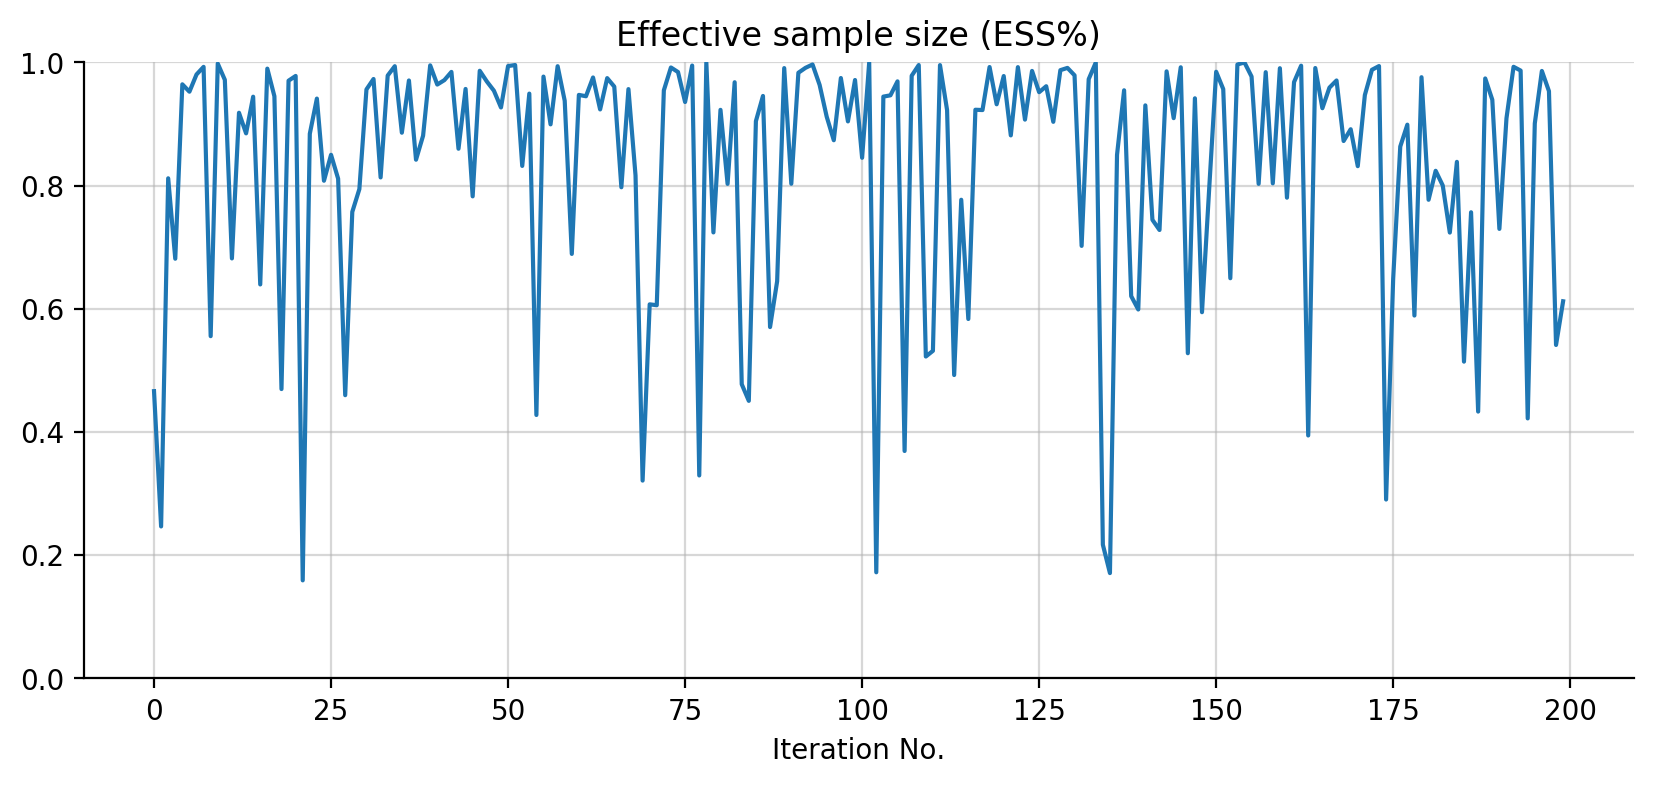

In [144]:
ess = 1 / jnp.power(hist_weights, 2).sum(axis=1)
ess = ess / n_particles

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ess)
ax.set_title("Effective sample size (ESS%)")
ax.set_xlabel("Iteration No.")
plt.ylim(0, 1)
ax.grid(alpha=0.5)